# LTCF application

```{cointents} Table of Contents
:depth: 3
```


"https://academic.oup.com/cid/article/74/1/113/6370508#google_vignette"

LTCFs have a high burden of norovirus outbreaks. Most LTCF norovirus outbreaks occurred during winter months and were spread person-to-person. Outbreak surveillance can inform development of interventions for this vulnerable population, such as vaccines targeting GII.4 norovirus strains.

For every 1000 cases, there were 21.6 hospitalizations and 2.3 deaths.


"https://www.sciencedirect.com/science/article/pii/S1755436523000075"




## Guided model building 

1. What populations should we consider?
2. Is this type of pathogen seasonal and recurring?
3. Do we expect different rates of commuting between specific populations? 
4. Can we visualize our model?
5. Can we write down the system of differential equations?
6. Can we code it?
7. Can we infer anything important from our model results? 


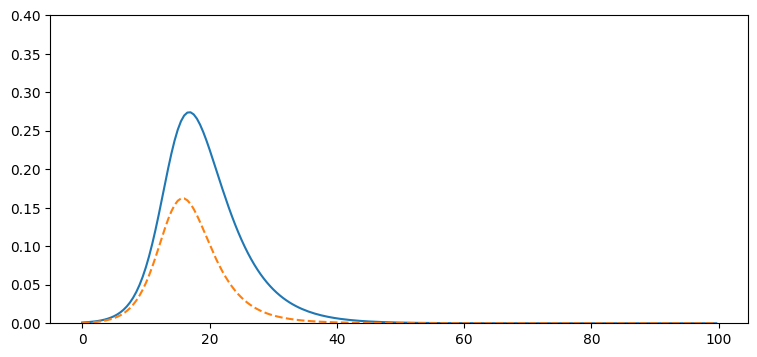

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


#-Population X is residents of a LTCF (Location X is the LTCF))
#-Population Y is clinical staff      (Location Y is the hospital)



def vary_rho(rho):
    def sir_two_populations(t, y, beta
                            ,gamma_clinician
                            ,gamma_resident
                            ,new_resident_enters_ltcf
                            ,new_clinician_is_hired
                            ,residents_come_back_from_hospital
                            ,residents_go_to_hospital
                            ,clinicians_come_back_to_hospital
                            ,clinicians_go_to_LTCF):
        Sxx,Sxy,Syx,Syy,Ixx,Ixy,Iyx,Iyy,  Nxx,Nxy,Nyx,Nyy = y

        #--LTCF (Resdients) Population------------------------------------------------------------------------------------------------------------------------------
        dSxx_dt = (new_resident_enters_ltcf)*Nxx-beta * Sxx * (Ixx + Iyx)/( Nxx + Nyx )   + residents_come_back_from_hospital*Sxy - residents_go_to_hospital*Sxx 
        dSxy_dt = (new_resident_enters_ltcf)  *Nxy-beta * Sxy * (Iyy + Ixy)/( Nyy + Nxy ) - residents_come_back_from_hospital*Sxy + residents_go_to_hospital*Sxx

        dIxx_dt = beta * Sxx * (Ixx + Iyx)/( Nxx + Nyx ) + residents_come_back_from_hospital*Ixy - residents_go_to_hospital*Ixx - gamma_resident*Ixx
        dIxy_dt = beta * Sxy * (Iyy + Ixy)/( Nyy + Nxy ) - residents_come_back_from_hospital*Ixy + residents_go_to_hospital*Ixx - gamma_resident*Ixy
        
        #--Clinicians Population------------------------------------------------------------------------------------------------------------------------------        
        dSyx_dt = new_clinician_is_hired*Nyx-beta * Syx * (Ixx + Iyx)/( Nxx + Nyx ) - clinicians_come_back_to_hospital*Syx + clinicians_go_to_LTCF*Syy
        dSyy_dt = new_clinician_is_hired*Nyy-beta * Syy * (Iyy + Ixy)/( Nyy + Nxy ) + clinicians_come_back_to_hospital*Syx - clinicians_go_to_LTCF*Syy

        dIyx_dt = beta * Syx * (Ixx + Iyx)/( Nxx + Nyx ) - clinicians_come_back_to_hospital*Iyx + clinicians_go_to_LTCF*Iyy - gamma_clinician*Iyx
        dIyy_dt = beta * Syy * (Iyy + Ixy)/( Nyy + Nxy ) + clinicians_come_back_to_hospital*Iyx - clinicians_go_to_LTCF*Iyy - gamma_clinician*Iyy
        
        #-- This piece first-----------------------------------------------------------------------
        #--residents of LTCF
        dNxx_dt    = residents_come_back_from_hospital * Nxy - residents_go_to_hospital * Nxx
        dNxy_dt    = -residents_come_back_from_hospital * Nxy + residents_go_to_hospital * Nxx

        #--Clinical Staff
        dNyy_dt    = clinicians_come_back_to_hospital * Nyx - clinicians_go_to_LTCF * Nyy 
        dNyx_dt    = -clinicians_come_back_to_hospital * Nyx + clinicians_go_to_LTCF * Nyy
        #----------------------------------------------------------------------------------------
        
        return [ dSxx_dt, dSxy_dt, dSyx_dt, dSyy_dt
               , dIxx_dt, dIxy_dt, dIyx_dt, dIyy_dt
               , dNxx_dt, dNxy_dt, dNyx_dt, dNyy_dt] 
    
    # Parameters
    beta      = 0.7             # Infection rate
    gamma_clinician  = 0.5      # Recovery rate
    gamma_resident   = 0.25     # Recovery rate
    
    new_resident_enters_ltcf = 0.#1./4
    new_clinician_is_hired   = 0.#1./52
    
    residents_come_back_from_hospital = 4.
    residents_go_to_hospital          = 1.

    clinicians_come_back_to_hospital  = 1.
    clinicians_go_to_LTCF             = 1.
    
    Nxx, Nyy = 1000, 10  # Population sizes
    Nxy, Nyx =    0, 0 # Population sizes

    # Initial conditions
    Sxx,Sxy,Syx,Syy = 999,0,0,10
    Ixx,Ixy,Iyx,Iyy = 1,0,0,0

    y0 = [Sxx,Sxy,Syx,Syy,Ixx,Ixy,Iyx,Iyy,Nxx,Nxy,Nyx,Nyy]
    
    # Time span
    t_span = (0, 500)  # 100 days
    t_eval = np.linspace(*t_span, (t_span[-1]-t_span[0])*2 )
    
    # Solve the system
    solution = solve_ivp(sir_two_populations
                         , t_span
                         , y0
                         , args   = (beta
                                    ,gamma_clinician
                                    ,gamma_resident
                                    ,new_resident_enters_ltcf
                                    ,new_clinician_is_hired
                                    ,residents_come_back_from_hospital
                                    ,residents_go_to_hospital
                                    ,clinicians_come_back_to_hospital
                                    ,clinicians_go_to_LTCF)
                         , t_eval = t_eval)
    return solution 
    

# Plot results
fig,ax = plt.subplots( 1,1, figsize=(9, 4))

solution = vary_rho(0)

Ix = solution.y[4] + solution.y[5]
Iy = solution.y[6] + solution.y[7]

ax.plot(solution.t[:200], Ix[:200]/1000 , label='I1 (Population 1)')
ax.set_ylim(0,0.40)

ax.plot(solution.t[:200], Iy[:200]/10,  label='I2 (Population 2)', linestyle='dashed')